In [1]:
try:
    from openmdao.utils.notebook_utils import notebook_mode  # noqa: F401
except ImportError:
    !python -m pip install openmdao[notebooks]

<script type="text/x-mathjax-config">
  MathJax.Hub.Config({
    TeX: {
      equationNumbers: {
        autoNumber: "AMS",
        useLabelIds: true
      }
    },
    displayAlign: "center"
  });
</script>

# Post-Optimality Sensitivities

Post-optimality sensitivities refer to the derivative of an optimization output wrt an optimization input.
These sensitivities are intended to inform the user of the cost of a design choice.
**These sensitivities only apply in the context of gradient-based optimization.**

## Viewing optimization as a nonlinear solve

From a MAUD perspective, one could view a gradient-based optimization as a nonlinear solve.

The implicit outputs in this context are the design varaible values, and the residual
equations come from the Karush-Kuhn-Tucker conditions for optimization.

### The Unconstrained Case

Consider the optimization of some function. Here is the standard form of the OpenMDAO 
paraboloid where we've replaced the constants with some parameters $p_0$, $p_1$, and $p_2$.

\begin{align}
\min_{x,\, y} \quad 
    & f(x, y; \mathbf{p}) = (x - p_0)^2 + x y + (y + p_1)^2 - p_2 \\
    \text{where} \quad 
    & \mathbf{p} = \begin{bmatrix} 3 \\ 4 \\ 3 \end{bmatrix} \in \mathbb{R}^3 \\
    & x, y \in \mathbb{R}
\end{align}

This system has 3 outputs ($f$, $x$, $y$) and 3 inputs ($\bar{p}$). So we may be interested in
in how those outputs change at the next converged solution subject to small changes in $\bar{p}$.

\begin{align}
    \frac{d x^*}{d \bar{p}} \\
    \frac{d y^*}{d \bar{p}} \\
    \frac{d f^*}{d \bar{p}} \\
\end{align}

In an unconstrained problem, the optimizer is finding the "bottom" of a multidimensional bowl:

\begin{align*}
  \mathcal{R_{KKT}}(\bar\theta, \bar{p}) = \nabla_\theta f(\bar{\theta}, \bar{p}) + \cancel{\lambda \nabla_\theta g(\bar{\theta}, \bar{p})} &= \bar{0}
\end{align*}

Where $\theta$ here represents the design variables instead of the typical $x$ in order to not confuse it with
the inputs the to the paraboloid above.
With two design variables, the residual vector $\mathcal{R_{KKT}}$ has two elements.

Our residual system has the following structure.

\begin{align*}
  \begin{bmatrix}
      \frac{df^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
  \begin{bmatrix}
      \frac{df}{d\bar{p}} \\
  \end{bmatrix}
  -
  \cancel{
    \begin{bmatrix}
      \frac{df}{d\bar{\theta}} \\
    \end{bmatrix}
  }
  \begin{bmatrix}
     \frac{d \mathcal{R}_{KKT}}{d\bar{\theta}}  \\
  \end{bmatrix}^{-1}
  \begin{bmatrix}
      \frac{d \mathcal{R}_{KKT}}{d\bar{p}} \\
  \end{bmatrix}
\end{align*}

or, expanding terms...

\begin{align*}
  \begin{bmatrix}
      \frac{df^*}{dp_0} & \frac{df^*}{dp_1} & \frac{df^*}{dp_2} \\
  \end{bmatrix}
  &=
  \begin{bmatrix}
      \frac{df}{dp_0} & \frac{df}{dp_1} & \frac{df}{dp_2} \\
  \end{bmatrix}
  -
  \cancel{
    \begin{bmatrix}
      \frac{df}{dx} & \frac{df}{dy} \\
    \end{bmatrix}
  }
  \begin{bmatrix}
      \frac{d\nabla_x f}{dx} & \frac{d\nabla_x f}{dy} \\
      \frac{d\nabla_y f}{dx} & \frac{d\nabla_y f}{dy} \\
  \end{bmatrix}^{-1}
  \begin{bmatrix}
      \frac{d\nabla_x f}{dp_0} & \frac{d\nabla_x f}{dp_1} & \frac{d\nabla_x f}{dp_2} \\
      \frac{d\nabla_y f}{dp_0} & \frac{d\nabla_y f}{dp_1} & \frac{d\nabla_y f}{dp_2} \\
  \end{bmatrix}
\end{align*}

In an unconstrained optimization such as this, the gradient $\left[\frac{df}{d\bar{\theta}}\right]$ is zero, so the post-optimality sensitivity of the objective wrt the parameters is identical to the total derivative of the objective wrt the parameters.

The following code generates plots that sweep the value of each parameter and plot the resulting objective value, overlaid by vectors indicating the calculated derivative $\frac{df^*}{dp_i}$.

[GRLAL0222090115:32650] shmem: mmap: an error occurred while determining whether or not /var/folders/zm/r34jq9lj0sx2qdt4pj65sfd00000gp/T//ompi.GRLAL0222090115.502/jf.0/2168258560/sm_segment.GRLAL0222090115.502.813d0000.0 could be created.


Nominal Solution:
   f*: [-27.33333333]
   x*: [6.66666667]
   y*: [-7.33333333]
   df*/dp0: [[-7.33333333]]
   df*/dp1: [[-6.66666667]]
   df*/dp2: [[-1.]]


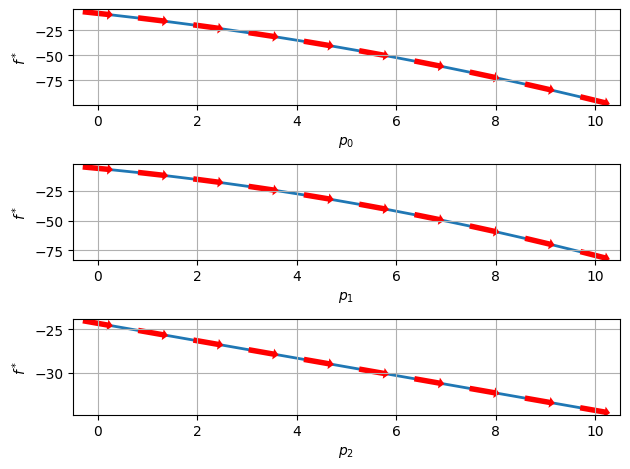

In [2]:
import numpy as np
import openmdao.api as om
import matplotlib.pyplot as plt

prob = om.Problem()
prob.model.add_subsystem('parab', om.ExecComp('f_xy = (x-p0)**2 + x*y + (y+p1)**2 - p2'),
                            promotes_inputs=['x', 'y', 'p0', 'p1', 'p2'],
                            promotes_outputs=['f_xy'])

# Design variables 'x' and 'y' span components, so we need to provide a common initial
# value for them.
prob.model.set_input_defaults('x', 3.0)
prob.model.set_input_defaults('y', -4.0)
prob.model.set_input_defaults('p0', 3.0)
prob.model.set_input_defaults('p1', 4.0)
prob.model.set_input_defaults('p2', 3.0)

# setup the optimization
prob.driver = om.pyOptSparseDriver()
prob.driver.options['print_results'] = False
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['singular_jac_behavior'] = 'ignore'

prob.model.add_design_var('x', lower=-50, upper=50)
prob.model.add_design_var('y', lower=-50, upper=50)
prob.model.add_objective('f_xy')

prob.setup()

prob.run_model()
driver_vars = prob.list_driver_vars(out_stream=None)
des_vars = [dv for dv, _ in driver_vars['design_vars']]
constraints = [dv for dv, _ in driver_vars['constraints']]
objs = [dv for dv, _ in driver_vars['objectives']]
other_ofs = []
other_wrts = ['p0', 'p1', 'p2']

ofs = objs + constraints + other_ofs
wrts = des_vars + other_wrts

fig, axs = plt.subplots(3, 1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

n_pts = 10
ps = np.linspace(0, 10, n_pts)
f_stars = np.zeros(n_pts)
df_stars_dps = np.zeros((3, n_pts))

prob.run_driver()
# No constraints, no lagrange multipliers
totals = prob.compute_totals(of=ofs, wrt=wrts, driver_scaling=False)

print('Nominal Solution:')
print('   f*:', prob.get_val('f_xy'))
print('   x*:', prob.get_val('x'))
print('   y*:', prob.get_val('y'))
print('   df*/dp0:', totals['f_xy', 'p0'])
print('   df*/dp1:', totals['f_xy', 'p1'])
print('   df*/dp2:', totals['f_xy', 'p2'])


for j in range(3):

    prob.set_val('p0', 3)
    prob.set_val('p1', 4)
    prob.set_val('p2', 3)

    for i, p in enumerate(ps):
        prob[f'p{j}'] = p
        prob.run_driver()
        f_stars[i] = np.copy(prob['f_xy'])[0]

        # est_multipliers, _ = prob.driver._get_lagrange_multipliers(driver_scaling=False, feas_tol=1.0E-6)

        totals = prob.compute_totals(of=ofs, wrt=wrts, driver_scaling=False)

        # dfstar_dg = est_multipliers['g']
        # dg_dp = totals['g', 'p0']
        dfstar_dpj= totals['f_xy', f'p{j}']

        # df_stars_dps[i] = np.copy(est_multipliers['g'] * (prob['x'] + prob['y']))
        df_stars_dps[j, i] = np.copy(dfstar_dpj).ravel()[0]



    uv = np.column_stack([np.ones_like(df_stars_dps[j]),
                            df_stars_dps[j]])

    uv_norm = np.linalg.norm(uv, axis=1)
    uv /= uv_norm[:, np.newaxis]

    axs[j].plot(ps,
                f_stars,
                zorder=0,
                linewidth=2.0)
    axs[j].quiver(ps,
                f_stars,
                uv[:,0],
                uv[:,1],
                angles="xy",
                pivot="mid",
                color="red",
                width=0.01,
                headwidth=2,
                headlength=1.0,
                headaxislength=1.0,
                minshaft=0.1,
                minlength=0.5)

    axs[j].set(xlabel=f'$p_{j}$', ylabel=r'$f^*$')
    axs[j].grid()

fig.tight_layout()

plt.show()

## Optimal design variable sensitivities for unconstrained optimization

In the section above, we demonstrate the ability to get the post-optimality sensitivity of the objective with respect to some parameters of the problem.

Now we want to know, how would the optimal values of $x$ and $y$ change as the values of $\bar{p}$ are changed?
The KKT residual is still the same for the unconstrained case.
Viewing the problem as an implicit solve, we have the following linear system for the residuals

\begin{align*}
  \begin{bmatrix}
      \frac{d{\bar{\theta}}^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
  \cancel{
    \begin{bmatrix}
      \frac{d{\bar{\theta}}}{d{\bar{p}}} \\
    \end{bmatrix}
  }
  -
  \begin{bmatrix}
      \frac{d{\bar{\theta}}}{d{\bar{\theta}}} \\
  \end{bmatrix}
  \begin{bmatrix}
    \frac{d\mathcal{R}_{KKT}}{d{\bar{\theta}}} \\
  \end{bmatrix}^{-1}
  \begin{bmatrix}
      \frac{d\mathcal{R}_{KKT}}{d\bar{p}} \\
  \end{bmatrix}
\end{align*}

The term $\frac{d{\bar{\theta}}}{d{\bar{p}}}$ drops to zero because the unoptimized design variables are not impacted by the choice of the parameters.
The term $\frac{d{\bar{\theta}}}{d{\bar{\theta}}}$ is just an identity matrix, so we're left with:

\begin{align*}
  \begin{bmatrix}
      \frac{d{\bar{\bar{\theta}}}^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
  -
  \begin{bmatrix}
    \frac{d\nabla_{\bar{\theta}} {f}}{d{\bar{\theta}}} \\
  \end{bmatrix}^{-1}
  \begin{bmatrix}
      \frac{d\nabla_{\bar{\theta}} {f}}{d\bar{p}} \\
  \end{bmatrix}
\end{align*}

or equivalently

\begin{align*}
  \begin{bmatrix}
    \frac{d\nabla_{\bar{\theta}} {f}}{d{\bar{\theta}}} \\
  \end{bmatrix}
  \begin{bmatrix}
      \frac{d{\bar{\theta}}^*}{d\bar{p}} \\
  \end{bmatrix}
  &=
  -
  \begin{bmatrix}
      \frac{d\nabla_{\bar{\theta}} {f}}{d\bar{p}} \\
  \end{bmatrix}
\end{align*}

So given $\frac{d\nabla_{\bar{\theta}} {f}}{d{\bar{\theta}}}$ and $\frac{d\nabla_{\bar{\theta}} {f}}{d\bar{p}}$, a linear solve provides the sensitivities $\frac{d{\bar{\theta}}^*}{d\bar{p}}$.

But how do we obtain these?

A derivative of a gradient is a second derivative, and OpenMDAO currently does not provide second derivatives.

### Enter the Lagrange Multipliers

In a constrained optimization problem, Lagrange multiplier terms are included in the KKT residual for each active constraint.
The presence of active constraints means that the optimization will not find the "bottom of the bowl", but rather be limited to finding some minimal value on the surface of the bowl where the active constraint residual is zero.

\begin{align*}
  \mathcal{R_{KKT}} =
  \begin{bmatrix}
  \nabla_{\bar{\theta}} f + \nabla_{\bar{\theta}} \bar{g}^T \bar\lambda + \nabla_{\bar{\theta}} \bar{h}^T_\mathcal{A} \bar\mu_\mathcal{A} + \bar\nu_\mathcal{A}
  \end{bmatrix} &= \bar{0}
\end{align*}

Where $\bar{g}$ are the equality constraints, $\bar{h}_\mathcal{A}$ are the active inequality constraints.

Lumping all active constraints and bounds into a single pseudo-equality-constraint vector $\mathcal{G}$, we have

\begin{align*}
  \nabla_{\bar{\theta}} \mathcal{G}^T \begin{bmatrix}\bar\lambda \\ \bar\mu \\ \bar\nu \end{bmatrix} = -\nabla_{\bar{\theta}} f
\end{align*}

For the sake of simplicity we're just going to use $\bar\lambda$ to encompass Lagrange multipliers for all active constraints from here on:

\begin{align*}
  \left[ \nabla_{\bar{\theta}} \mathcal{G}^T \right] \bar\lambda = - \left[ \nabla_{\bar{\theta}} f \right]
\end{align*}

The gradients in the above equation are obtained by a call to OpenMDAO's `problem.compute_totals` method.

From this we can find the multipliers using a least squares method in order to allow a little slack due to numerical issues.
These multipliers give the _post-optimality sensitivities_ of the objective $f$ with respect to the active constraint bound values for the equality constraints, inequality constraints, and design variables, respectively.

Now suppose, having already found the optimal solution that satisfies the KKT conditions, we treat the design variable vector $\bar\theta$ as if it were equality-constrained to those optimal values:

\begin{align*}
  \mathcal{G} = \begin{bmatrix}x - x* \\ y - y* \end{bmatrix} &= \left[ 0 \right]
\end{align*}

Since OpenMDAO doesn't provide second derivative information at this time, we rely on finite-difference for this step.
If we were to perturb the design variables $x$ and $y$ away from their optimal values and solve the KKT system, the resulting multpliers would approximate the sensitivities of the objective with respect to the design variables constrained to their optimal values, $\frac{d f^*}{d{{\bar{\theta}}}}$.

\begin{align}
    \frac{d^2 f^*}{d\bar{\theta}^2} &\approx \frac{-\bar{\lambda}(\bar{\theta^*} + \Delta h, \bar{p}) - (-\bar{\lambda}(\bar{\theta^*}, \bar{p}))}{\Delta h}
\end{align}

Similarly, a perturbation of the parameter values and treating them as if they were constraints would give us $\frac{d\nabla_{{\bar{\theta}}} {f}}{d{\bar{p}}}$.

\begin{align}
    \frac{d^2 f^*}{d\bar{\theta}d\bar{p}} &\approx \frac{-\bar{\lambda}(\theta^*, \bar{p} + \Delta h) - (-\bar{\lambda}(\theta^*, \bar{p}))}{\Delta h}
\end{align}


In [1]:
import numpy as np
import openmdao.api as om
import matplotlib.pyplot as plt

prob = om.Problem()
prob.model.add_subsystem('parab', om.ExecComp('f = (x-p0)**2 + x*y + (y+p1)**2 - p2'),
                            promotes_inputs=['x', 'y', 'p0', 'p1', 'p2'],
                            promotes_outputs=['f'])

# Design variables 'x' and 'y' span components, so we need to provide a common initial
# value for them.
prob.model.set_input_defaults('x', 3.0)
prob.model.set_input_defaults('y', -4.0)
prob.model.set_input_defaults('p0', 3.0)
prob.model.set_input_defaults('p1', 4.0)
prob.model.set_input_defaults('p2', 3.0)

# setup the optimization
prob.driver = om.pyOptSparseDriver()
prob.driver.options['print_results'] = False
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['singular_jac_behavior'] = 'ignore'

prob.model.add_design_var('x', lower=-50, upper=50)
prob.model.add_design_var('y', lower=-50, upper=50)
prob.model.add_objective('f')

prob.setup()

PERTURB_H = 1.0E-7

p0 = 3.
p1 = 4.
p2 = 3.
prob.set_val('p0', p0)
prob.set_val('p1', p1)
prob.set_val('p2', p2)

prob.run_driver()

fstar = np.copy(prob.get_val('f'))
xstar = np.copy(prob.get_val('x'))
ystar = np.copy(prob.get_val('y'))

# # NOTE: We get the wrong answers if we don't use np.copy here.
# fstar = prob.get_val('f')
# xstar = prob.get_val('x')
# ystar = prob.get_val('y')

print('f*', fstar)
print('x*', xstar)
print('y*', ystar)

print()

# The nominal multipliers
nom_mult, actives = prob.driver._get_lagrange_multipliers(driver_scaling=False, feas_tol=1.0E-6)

print(nom_mult)

driver_vars = prob.list_driver_vars(out_stream=None)
des_vars = [dv for dv, _ in driver_vars['design_vars']]
constraints = [dv for dv, _ in driver_vars['constraints']]
objs = [dv for dv, _ in driver_vars['objectives']]
other_ofs = []
other_wrts = ['p0', 'p1', 'p2']

ofs = objs + constraints + other_ofs
wrts = des_vars + other_wrts

totals = prob.compute_totals(of=ofs, wrt=wrts, driver_scaling=False)

# Perturb the design variables to obtain dgradf/dtheta
# First do x

prob.set_val('x', xstar + PERTURB_H)
prob.run_model()

dR_dtheta = np.zeros((2, 2), dtype=float)

pert_mult, actives = prob.driver._get_lagrange_multipliers(driver_scaling=False, feas_tol=1.0E-6, assume_dvs_active=True)
print('\nperturbed x sensitivities via lagrange multipliers')
print('  x', -pert_mult['x'] / PERTURB_H)
print('  y', -pert_mult['y'] / PERTURB_H)
dR_dtheta[0, 0] = -pert_mult['x'][0] / PERTURB_H
dR_dtheta[1, 0] = -pert_mult['y'][0] / PERTURB_H
# Now do y
prob.set_val('x', xstar)
prob.set_val('y', ystar + PERTURB_H)
prob.run_model()

pert_mult, actives = prob.driver._get_lagrange_multipliers(driver_scaling=False, feas_tol=1.0E-6, assume_dvs_active=True)
print('\nperturbed y sensitivities via lagrange multipliers')
print('  x', -pert_mult['x'] / PERTURB_H)
print('  y', -pert_mult['y'] / PERTURB_H)
# dR_dtheta[:, 1] = np.ravel(-pert_mult['x'] / PERTURB_H)
dR_dtheta[0, 1] = -pert_mult['x'][0] / PERTURB_H
dR_dtheta[1, 1] = -pert_mult['y'][0] / PERTURB_H

# dR/dtheta
print(dR_dtheta)

# Reset back to optimal values
prob.set_val('x', xstar)
prob.set_val('y', ystar)
prob.run_model()

dR_dp = np.zeros((2, 3), dtype=float)

# THE PERTURBED P0 GRADIENTS

prob.set_val('p0', p0 + PERTURB_H)
prob.run_model()

pert_mult, actives = prob.driver._get_lagrange_multipliers(driver_scaling=False, feas_tol=1.0E-6, assume_dvs_active=True)
print('\nperturbed p0 sensitivities via lagrange multipliers')
print('  x', -pert_mult['x'] / PERTURB_H)
print('  y', -pert_mult['y'] / PERTURB_H)

dR_dp[0, 0] = -pert_mult['x'][0] / PERTURB_H
dR_dp[1, 0] = -pert_mult['y'][0] / PERTURB_H

prob.set_val('p0', p0)
prob.set_val('p1', p1 + PERTURB_H)
prob.run_model()

pert_mult, actives = prob.driver._get_lagrange_multipliers(driver_scaling=False, feas_tol=1.0E-6, assume_dvs_active=True)
print('\nperturbed p1 sensitivities via lagrange multipliers')
print('  x', -pert_mult['x'][0] / PERTURB_H)
print('  y', -pert_mult['y'][0] / PERTURB_H)

dR_dp[0, 1] = -pert_mult['x'][0] / PERTURB_H
dR_dp[1, 1] = -pert_mult['y'][0] / PERTURB_H

prob.set_val('p1', p1)
prob.set_val('p2', p2 + PERTURB_H)
prob.run_model()

pert_mult, actives = prob.driver._get_lagrange_multipliers(driver_scaling=False, feas_tol=1.0E-6, assume_dvs_active=True)
print('\nperturbed p2 sensitivities via lagrange multipliers')
print(-pert_mult['x'] / PERTURB_H)
print(-pert_mult['y'] / PERTURB_H)

dR_dp[0, 2] = -pert_mult['x'][0] / PERTURB_H
dR_dp[1, 2] = -pert_mult['y'][0] / PERTURB_H

dthetastar_dp, optimality_squared, rank, singular_vals = np.linalg.lstsq(dR_dtheta, -dR_dp, rcond=None)

print(dthetastar_dp)

dfstar_dp = np.hstack((totals['f', 'p0'], totals['f', 'p1'], totals['f', 'p2']))

print('df*/dp0', totals['f', 'p0'])
print('df*/dp1', totals['f', 'p1'])
print('df*/dp2', totals['f', 'p2'])

sensitivity_matrix = np.vstack((dfstar_dp, dthetastar_dp))

[GRLAL0222090115:52644] shmem: mmap: an error occurred while determining whether or not /var/folders/zm/r34jq9lj0sx2qdt4pj65sfd00000gp/T//ompi.GRLAL0222090115.502/jf.0/855179264/sm_segment.GRLAL0222090115.502.32f90000.0 could be created.


f* [-27.33333333]
x* [6.66666667]
y* [-7.33333333]

active cons mat
[]
grad_f_vec
[-0.00000000e+00 -8.15663058e-16]
{}
active cons mat
[[1. 0.]
 [0. 1.]]
grad_f_vec
[2.00000000e-07 9.99999998e-08]

perturbed x sensitivities via lagrange multipliers
  x [2.]
  y [1.]
active cons mat
[[1. 0.]
 [0. 1.]]
grad_f_vec
[1.00000001e-07 2.00000000e-07]

perturbed y sensitivities via lagrange multipliers
  x [1.00000001]
  y [2.]
[[2.         1.00000001]
 [1.         2.        ]]
active cons mat
[[1. 0.]
 [0. 1.]]
grad_f_vec
[-2.00000000e-07 -8.15663058e-16]

perturbed p0 sensitivities via lagrange multipliers
  x [-2.]
  y [-8.15663058e-09]
active cons mat
[[1. 0.]
 [0. 1.]]
grad_f_vec
[-0.e+00  2.e-07]

perturbed p1 sensitivities via lagrange multipliers
  x -0.0
  y 1.9999999956073102
active cons mat
[[1. 0.]
 [0. 1.]]
grad_f_vec
[-0.00000000e+00 -8.15663058e-16]

perturbed p2 sensitivities via lagrange multipliers
[-0.]
[-8.15663058e-09]
[[ 1.33333333e+00  6.66666670e-01 -2.71887688e-09]
 [-6

In [5]:
import numpy as np
from bokeh.plotting import figure, show
from bokeh.models import (
    ColumnDataSource, ColorBar, LinearColorMapper, BasicTicker,
    PrintfTickFormatter, LabelSet
)
from bokeh.transform import transform
# from seaborn import diverging_palette

# Sensitivity matrix
matrix = sensitivity_matrix[::-1, :]
original_matrix = matrix.copy()

row_labels = ['f*', 'x*', 'y*']
col_labels = ['p0', 'p1', 'p2']
nrows, ncols = matrix.shape

# Flatten for plotting
x = np.tile(col_labels, nrows)
y = np.repeat(row_labels[::-1], ncols)  # Reverse so 'f' is at the top
values = matrix.flatten()

# Normalize to get text contrast
norm_vals = (values - matrix.min()) / (matrix.max() - matrix.min())
text_colors = ['black' if val > 0.5 else 'white' for val in norm_vals]

source = ColumnDataSource(data=dict(
    x=x,
    y=y,
    value=values,
    text_labels=[f"{v:.2f}" for v in values],
    text_color=text_colors
))

# Color mapper
cmap_min = np.min((matrix.min(), -matrix.max()))
cmap_max = np.max((matrix.max(), -matrix.min()))

purple_green = [270, 120]
blue_orange = [240, 30]
blue_red = [240, 10]
teal_rust = [200, 10]
slate_yellow = [220, 60]

# pal = diverging_palette(*blue_red, center='light', n=max(matrix.size, 256)).as_hex()
# hex_palette = [seaborn.utils.rgb2hex(rgb) for rgb in pal]

PuGr_256 = ['#7865db', '#7966db', '#7a67db', '#7b68db', '#7c69dc', '#7d6bdc', '#7e6cdc', '#7f6ddc',
            '#806edc', '#816fdc', '#8170dd', '#8271dd', '#8372dd', '#8473dd', '#8574dd', '#8676de',
            '#8777de', '#8878de', '#8979de', '#8a7ade', '#8b7bde', '#8c7cdf', '#8d7ddf', '#8e7edf',
            '#8f7fdf', '#9081df', '#9182e0', '#9283e0', '#9384e0', '#9485e0', '#9486e0', '#9587e1',
            '#9688e1', '#9789e1', '#988ae1', '#998be1', '#9a8de1', '#9b8ee2', '#9c8fe2', '#9d90e2',
            '#9e91e2', '#9f92e2', '#a093e3', '#a194e3', '#a295e3', '#a396e3', '#a498e3', '#a599e3',
            '#a69ae4', '#a79be4', '#a79ce4', '#a89de4', '#a99ee4', '#aa9fe5', '#aba0e5', '#aca1e5',
            '#ada3e5', '#aea4e5', '#afa5e5', '#b0a6e6', '#b1a7e6', '#b2a8e6', '#b3a9e6', '#b4aae6',
            '#b5ace7', '#b6ade7', '#b7aee7', '#b8afe7', '#b9b0e7', '#bab1e8', '#bbb2e8', '#bcb4e8',
            '#bdb5e8', '#beb6e8', '#bfb7e9', '#c0b8e9', '#c1b9e9', '#c2bae9', '#c3bbe9', '#c3bce9',
            '#c4bdea', '#c5beea', '#c6c0ea', '#c7c1ea', '#c8c2ea', '#c9c3eb', '#cac4eb', '#cbc5eb',
            '#ccc6eb', '#cdc7eb', '#cec8eb', '#cfc9ec', '#d0cbec', '#d1ccec', '#d2cdec', '#d3ceec',
            '#d4cfed', '#d5d0ed', '#d6d1ed', '#d6d2ed', '#d7d3ed', '#d8d4ee', '#d9d6ee', '#dad7ee',
            '#dbd8ee', '#dcd9ee', '#dddaee', '#dedbef', '#dfdcef', '#e0ddef', '#e1deef', '#e2dfef',
            '#e3e1f0', '#e4e2f0', '#e5e3f0', '#e6e4f0', '#e7e5f0', '#e8e6f0', '#e9e7f1', '#e9e8f1',
            '#eae9f1', '#ebeaf1', '#ecebf1', '#ededf2', '#eeeef2', '#efeff2', '#f0f0f2', '#f1f1f2',
            '#eff2ef', '#ecf2ea', '#ebf1e9', '#e9f0e7', '#e8efe6', '#e7eee4', '#e6eee3', '#e4ede2',
            '#e3ece0', '#e2ebdf', '#e1eadd', '#dfe9dc', '#dee8db', '#dde8d9', '#dce7d8', '#dae6d6',
            '#d9e5d5', '#d8e4d4', '#d7e3d2', '#d6e2d1', '#d4e1cf', '#d3e1ce', '#d2e0cd', '#d1dfcb',
            '#cfdeca', '#ceddc8', '#cddcc7', '#ccdbc6', '#cadac4', '#c9dac3', '#c8d9c1', '#c7d8c0',
            '#c5d7bf', '#c4d6bd', '#c3d5bc', '#c2d4ba', '#c0d3b9', '#bfd3b8', '#bed2b6', '#bdd1b5',
            '#bcd0b3', '#bacfb2', '#b9ceb1', '#b8cdaf', '#b7cdae', '#b5ccac', '#b4cbab', '#b3caa9',
            '#b2c9a8', '#b0c8a7', '#afc7a5', '#aec6a4', '#adc6a2', '#abc5a1', '#aac4a0', '#a9c39e',
            '#a8c29d', '#a6c19b', '#a5c09a', '#a4bf99', '#a3bf97', '#a2be96', '#a0bd94', '#9fbc93',
            '#9dbb91', '#9cba90', '#9bb98e', '#99b88d', '#98b78b', '#97b68a', '#96b588', '#95b587',
            '#93b486', '#92b384', '#91b283', '#90b181', '#8eb080', '#8daf7f', '#8cae7d', '#8bae7c',
            '#89ad7a', '#88ac79', '#87ab78', '#86aa76', '#84a975', '#83a873', '#82a872', '#81a771',
            '#80a66f', '#7ea56e', '#7da46c', '#7ca36b', '#7ba26a', '#79a168', '#78a167', '#77a065',
            '#769f64', '#749e63', '#739d61', '#729c60', '#719b5e', '#6f9a5d', '#6e9a5c', '#6d995a',
            '#6c9859', '#6a9757', '#699656', '#689555', '#679453', '#669352', '#649350', '#63924f',
            '#62914e', '#61904c', '#5f8f4b', '#5e8e49', '#5d8d48', '#5c8d46', '#5a8c45', '#598b44',
            '#588a42', '#578941', '#55883f', '#54873e', '#53863d', '#52863b', '#51853a', '#4f8438']

BuRd_256 = ['#417ca8', '#437da8', '#447ea9', '#467fa9', '#4780aa', '#4881aa', '#4a82ab', '#4b83ac',
            '#4c84ac', '#4e84ad', '#4f85ad', '#5086ae', '#5287af', '#5388af', '#5589b0', '#568ab0',
            '#578bb1', '#598cb2', '#5a8db2', '#5b8eb3', '#5d8fb3', '#5e8fb4', '#6090b4', '#6191b5',
            '#6292b6', '#6493b6', '#6594b7', '#6695b7', '#6896b8', '#6997b9', '#6b98b9', '#6c99ba',
            '#6d9aba', '#6f9bbb', '#709bbc', '#719cbc', '#739dbd', '#749ebd', '#759fbe', '#77a0be',
            '#78a1bf', '#7aa2c0', '#7ba3c0', '#7ca4c1', '#7ea5c1', '#7fa6c2', '#80a6c3', '#82a7c3',
            '#83a8c4', '#85a9c4', '#86aac5', '#87abc6', '#89acc6', '#8aadc7', '#8baec7', '#8dafc8',
            '#8eb0c8', '#90b1c9', '#91b1ca', '#92b2ca', '#94b3cb', '#95b4cb', '#96b5cc', '#98b6cd',
            '#9ab7cd', '#9bb8ce', '#9db9cf', '#9ebacf', '#9fbbd0', '#a1bcd0', '#a2bdd1', '#a3bed2',
            '#a5bfd2', '#a6c0d3', '#a8c1d3', '#a9c1d4', '#aac2d5', '#acc3d5', '#adc4d6', '#aec5d6',
            '#b0c6d7', '#b1c7d7', '#b3c8d8', '#b4c9d9', '#b5cad9', '#b7cbda', '#b8ccda', '#b9ccdb',
            '#bbcddc', '#bccedc', '#bdcfdd', '#bfd0dd', '#c0d1de', '#c2d2df', '#c3d3df', '#c4d4e0',
            '#c6d5e0', '#c7d6e1', '#c8d7e1', '#cad8e2', '#cbd8e3', '#cdd9e3', '#cedae4', '#cfdbe4',
            '#d1dce5', '#d2dde6', '#d3dee6', '#d5dfe7', '#d6e0e7', '#d8e1e8', '#d9e2e9', '#dae3e9',
            '#dce3ea', '#dde4ea', '#dee5eb', '#e0e6eb', '#e1e7ec', '#e2e8ed', '#e4e9ed', '#e5eaee',
            '#e7ebee', '#e8ecef', '#e9edf0', '#ebeef0', '#eceef1', '#edeff1', '#eff0f2', '#f1f1f2',
            '#f2f1f1', '#f2efef', '#f2eeee', '#f2eded', '#f2ebeb', '#f1eaea', '#f1e8e9', '#f1e7e7',
            '#f1e5e6', '#f1e4e5', '#f0e3e3', '#f0e1e2', '#f0e0e1', '#f0dedf', '#f0ddde', '#efdbdd',
            '#efdadb', '#efd9da', '#efd7d9', '#efd6d7', '#efd4d6', '#eed3d5', '#eed1d3', '#eed0d2',
            '#eecfd1', '#eecdcf', '#edccce', '#edcacd', '#edc9cb', '#edc7ca', '#edc6c9', '#ecc5c7',
            '#ecc3c6', '#ecc2c5', '#ecc0c3', '#ecbfc2', '#ebbdc1', '#ebbcbf', '#ebbbbe', '#ebb9bd',
            '#ebb8bb', '#eab6ba', '#eab5b9', '#eab3b7', '#eab2b6', '#eab0b5', '#eaafb3', '#e9aeb2',
            '#e9acb1', '#e9abaf', '#e9a9ae', '#e9a8ad', '#e8a6ab', '#e8a5aa', '#e8a4a9', '#e8a2a7',
            '#e8a1a6', '#e79fa5', '#e79ea3', '#e79ca2', '#e79ba1', '#e79a9f', '#e6989e', '#e6979d',
            '#e6959b', '#e69399', '#e69298', '#e59097', '#e58f95', '#e58d94', '#e58c93', '#e58b91',
            '#e48990', '#e4888f', '#e4868d', '#e4858c', '#e4838b', '#e38289', '#e38188', '#e37f87',
            '#e37e85', '#e37c84', '#e37b83', '#e27981', '#e27880', '#e2777f', '#e2757d', '#e2747c',
            '#e1727b', '#e17179', '#e16f78', '#e16e77', '#e16d75', '#e06b74', '#e06a73', '#e06871',
            '#e06770', '#e0656f', '#df646d', '#df636c', '#df616b', '#df6069', '#df5e68', '#df5d67',
            '#de5b65', '#de5a64', '#de5963', '#de5761', '#de5660', '#dd545e', '#dd535d', '#dd515c',
            '#dd505a', '#dd4f59', '#dc4d58', '#dc4c56', '#dc4a55', '#dc4954', '#dc4752', '#db4651',
            '#db4550', '#db434e', '#db424d', '#db404c', '#da3f4a', '#da3d49', '#da3c48', '#da3b46']

# while pal:
#     print(pal[:8])
#     del pal[:8]

# Now use this in Bokeh's color mapper
mapper = LinearColorMapper(palette=BuRd_256, low=cmap_min, high=cmap_max)

p = figure(title="OpenMDAO Sensitivity Heatmap",
           x_range=col_labels, y_range=list(reversed(row_labels)),
           x_axis_location="above", width=600, height=600,
           tools="", toolbar_location=None)

p.rect(x="x", y="y", width=1, height=1, source=source,
       fill_color=transform('value', mapper), line_color=None)

TEXT_FONT_SIZE = '16pt'

labels = LabelSet(x='x', y='y', text='text_labels', text_color='text_color',
                  source=source, text_align='center', text_baseline='middle',
                  text_font_size=TEXT_FONT_SIZE)

p.xaxis.axis_label_text_font_size = TEXT_FONT_SIZE
p.xaxis.major_label_text_font_size = TEXT_FONT_SIZE
p.yaxis.axis_label_text_font_size = TEXT_FONT_SIZE
p.yaxis.major_label_text_font_size = TEXT_FONT_SIZE

p.add_layout(labels)

color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=10),
                     formatter=PrintfTickFormatter(format="%.2f"))

color_bar.major_label_text_font_size = TEXT_FONT_SIZE

p.add_layout(color_bar, 'right')

# TextInput widgets for scaling
# inputs = [TextInput(value="1.0", title=f"Scale for {label}") for label in col_labels]

# JavaScript callback to apply scaling
# callback = CustomJS(args=dict(source=source, inputs=inputs), code=f"""
#     const data = source.data;
#     const scales = inputs.map(inp => parseFloat(inp.value) || 1.0);
#     const orig = {sensitivity_matrix};
#     const x = data['x'];
#     const y = data['y'];
#     const new_vals = [];
#     const new_labels = [];
#     const new_colors = [];
#     """
#     +
#     """
#     function getTextColor(v, vmin, vmax) {
#         const norm = (v - vmin) / (vmax - vmin);
#         return norm > 0.5 ? 'black' : 'white';
#     }

#     let vmin = Infinity, vmax = -Infinity;

#     for (let i = 0; i < 3; i++) {         // rows
#         for (let j = 0; j < 3; j++) {     // cols
#             const v = orig[i][j] * scales[j];
#             new_vals.push(v);
#             if (v < vmin) vmin = v;
#             if (v > vmax) vmax = v;
#         }
#     }

#     for (let k = 0; k < new_vals.length; k++) {
#         new_labels[k] = new_vals[k].toFixed(2);
#     }

#     for (let k = 0; k < new_vals.length; k++) {
#         new_colors[k] = getTextColor(new_vals[k], vmin, vmax);
#     }

#     data['value'] = new_vals;
#     data['text_labels'] = new_labels;
#     data['text_color'] = new_colors;
#     source.change.emit();
# """)

# # Connect widgets to callback
# for inp in inputs:
#     inp.js_on_change("value", callback)

# Layout
# layout = column(p, row(*inputs))
# curdoc().add_root(layout)

show(p)

## Vectorized Systems

Suppose both the design variables and the parameters contain vectors.
The same math holds, but we need to make sure that

In [ ]:
import numpy as np
import openmdao.api as om
import matplotlib.pyplot as plt

prob = om.Problem()
prob.model.add_subsystem('parab', om.ExecComp(['f = (theta[0] - p[0])**2 + theta[0] * theta[1] + (theta[1] + p[1])**2 - p[2]'],
                                            #    'h = theta[1] - theta[0] + 5'],
                                               theta = {'shape': (2,),},
                                               p = {'shape': (3,)}),
                            promotes_inputs=['theta', 'p'],
                            promotes_outputs=['f'])#, 'h'])

# Design variables 'x' and 'y' span components, so we need to provide a common initial
# value for them.
prob.model.set_input_defaults('theta', [3.0, -4.0])
prob.model.set_input_defaults('p', [3.0, 4.0, 3.0])

# setup the optimization
prob.driver = om.pyOptSparseDriver()
prob.driver.options['print_results'] = False
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['singular_jac_behavior'] = 'ignore'

prob.model.add_design_var('theta', lower=-50, upper=50)
prob.model.add_objective('f')

prob.setup()

p0 = 3.
p1 = 4.
p2 = 3.
prob.set_val('p', [p0, p1, p2])

prob.run_driver()

fstar = np.copy(prob.get_val('f'))
xstar, ystar = np.copy(prob.get_val('theta'))

print('f*', fstar)
print('x*', xstar)
print('y*', ystar)

print(prob.driver.compute_sensitivites(wrt=['p']))


f* [-27.33333333]
x* 6.666666666666667
y* -7.333333333333334
[[-7.33333333e+00 -6.66666667e+00 -1.00000000e+00]
 [ 1.33333341e+00  6.66666721e-01 -2.71887727e-08]
 [-6.66666721e-01 -1.33333339e+00  5.43775431e-08]]
